In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Import local modules

In [2]:
import os
import sys
module_path_lupft = '/home/glemieux/Repos/NGEET/fates/tools/landuse/src/landusepft/'
sys.path.append(module_path_lupft)
from landusepftmod import ImportLandusePFTFile, ImportStaticLUH2File
from landusepftmod import RenormalizePFTs, AddLatLonCoordinates  #CoordinateConversion
module_path_luh2 = '/home/glemieux/Repos/NGEET/fates/tools/luh2/'
sys.path.append(module_path_luh2)
from luh2mod import SetMaskSurfData, SetMaskLUH2, ImportData, BoundsVariableFixLUH2

### Define helper plot function

In [3]:
def plotnatpft(variable, colormap='magma_r'):
    fg = variable.plot(x='lon',y='lat',col='natpft', col_wrap=4, cmap=colormap, 
                   transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), add_colorbar=False)

    for ax in fg.axes.flat:
        ax.coastlines() 

    # color bar
    fg.add_colorbar(orientation="vertical", shrink=0.6, anchor=(1.5, 0.5))
    plt.subplots_adjust(hspace=-0.65)

### Import data

In [4]:
luh2_static_file = '/home/glemieux/Data/luh2/staticData_quarterdeg.nc'
regrid_target_file = '/home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
clm_surface_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_surf_deg025.nc'
clm_forest_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhforest_deg025.nc'
clm_pasture_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhpasture_deg025.nc'
clm_other_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhother_deg025.nc'
statefile = '/home/glemieux/Data/luh2/states.nc'
filelist = [clm_surface_file, clm_forest_file, clm_pasture_file, clm_other_file]

In [5]:
ds_states = ImportData(statefile)

Input file dataset opened: /home/glemieux/Data/luh2/states.nc
PrepDataset: LUH2
LUH2 dataset lat/lon boundary variables formatted and added as new variable for xESMF
data set updated for xESMF



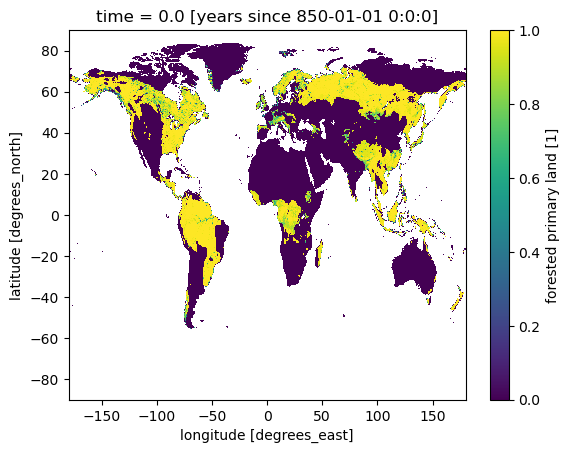

In [6]:
ds_states.primf.isel(time=0).plot()

In [7]:
ds_states.isel(time=0)

<xarray.Dataset>
Dimensions:    (lat: 720, lon: 1440, lat_b: 721, lon_b: 1441)
Coordinates:
    time       float64 0.0
  * lat        (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon        (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat_b      (lat_b) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon_b      (lon_b) float64 -180.0 -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
Data variables: (12/15)
    primf      (lat, lon) float32 ...
    primn      (lat, lon) float32 ...
    secdf      (lat, lon) float32 ...
    secdn      (lat, lon) float32 ...
    urban      (lat, lon) float32 ...
    c3ann      (lat, lon) float32 ...
    ...         ...
    c3nfx      (lat, lon) float32 ...
    pastr      (lat, lon) float32 ...
    range      (lat, lon) float32 ...
    secmb      (lat, lon) float32 ...
    secma      (lat, lon) float32 ...
    timesince  int64 850
Attributes: (12/17)
    host:              UMD College Park
    comment:           LUH2
    contact:           gchurtt@umd.edu, lchini@umd.edu, steve.frolking@unh.ed...
    creation_date:     2016-10-12T18:26:36Z
    title:             Land-Use Harmonization Data Sets
    activity_id:       input4MIPs
    ...                ...
    further_info_url:  http://luh.umd.edu
    frequency:         yr
    institution_id:    UofMD
    institution:       University of Maryland College Park
    realm:             land
    references:        Hurtt, Chini et al. 2011

In [8]:
ds_landusepfts = []
for filename in filelist:
    ds_landusepfts.append(ImportLandusePFTFile(filename))

In [9]:
ds_static = ImportData(luh2_static_file)

Input file dataset opened: /home/glemieux/Data/luh2/staticData_quarterdeg.nc


In [10]:
ds_target = ImportData(regrid_target_file)

Input file dataset opened: /home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc
PrepDataset: SurfData
Surface dataset dimensions renamed for xESMF
data set updated for xESMF



In [11]:
ds_landusepfts[2]

<xarray.Dataset>
Dimensions:      (natpft: 15, cft: 64, lat: 720, lon: 1440)
Coordinates:
  * natpft       (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft          (cft) int32 15 16 17 18 19 20 21 22 ... 71 72 73 74 75 76 77 78
Dimensions without coordinates: lat, lon
Data variables:
    EDGEN        float64 90.0
    EDGEE        float64 180.0
    EDGES        float64 -90.0
    EDGEW        float64 -180.0
    LAT          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
    LATIXY       (lat, lon) float32 -89.88 -89.88 -89.88 ... 89.88 89.88 89.88
    LON          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    LONGXY       (lat, lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    LANDMASK     (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    LANDFRAC     (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    AREA         (lat, lon) float32 3.379 3.379 3.379 ... 4.742e-14 4.742e-14
    PCT_NAT_PFT  (natpft, lat, lon) float64 100.0 100.0 100.0 ... 0.0 0.0 0.0
Attributes:
    source:         Peter Lawrence, NCAR
    creation_date:  Thu Jun 15 14:56:38 MDT 2017
    title:          CLM5_current_luhpasture_deg025.nc

In [11]:
ds_static

<xarray.Dataset>
Dimensions:     (lon: 1440, lat: 720, bounds: 2)
Coordinates:
  * lon         (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat         (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
Dimensions without coordinates: bounds
Data variables:
    ptbio       (lat, lon) float32 ...
    fstnf       (lat, lon) float32 ...
    carea       (lat, lon) float32 ...
    icwtr       (lat, lon) float32 ...
    ccode       (lat, lon) float32 ...
    lat_bounds  (lat, bounds) float32 ...
    lon_bounds  (lon, bounds) float32 ...
Attributes: (12/17)
    history:           Processed: 2016-10-12T14:10:57Z
    host:              UMD College Park
    comment:           LUH2
    contact:           gchurtt@umd.edu, lchini@umd.edu, steve.frolking@unh.ed...
    creation_date:     2016 10 12 14:10
    title:             Land Use Data Sets
    ...                ...
    license:           MIT
    further_info_url:  http://luh.umd.edu
    frequency:         yr
    instituition:      University of Maryland College Park
    realm:             land
    references:        Hurtt, Chini et al. 2011

In [12]:
ds_target.LONGXY.values

array([[  0.,   5.,  10., ..., 345., 350., 355.],
       [  0.,   5.,  10., ..., 345., 350., 355.],
       [  0.,   5.,  10., ..., 345., 350., 355.],
       ...,
       [  0.,   5.,  10., ..., 345., 350., 355.],
       [  0.,   5.,  10., ..., 345., 350., 355.],
       [  0.,   5.,  10., ..., 345., 350., 355.]])

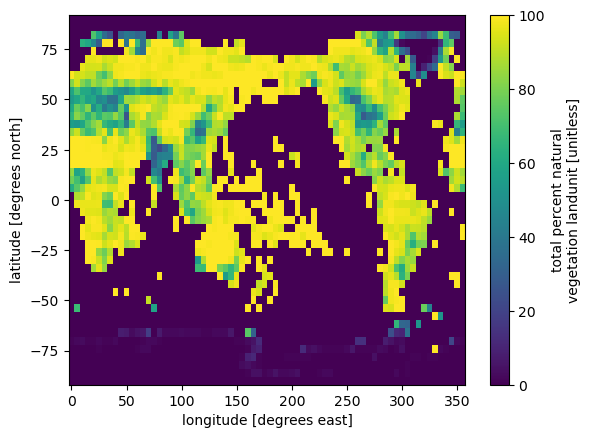

In [13]:
ds_target.PCT_NATVEG.plot()

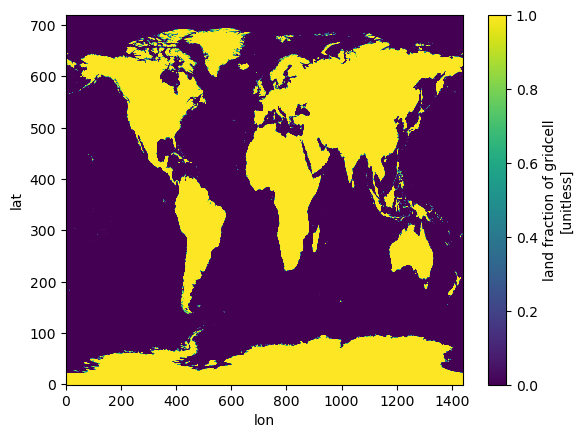

In [14]:
ds_landusepfts[1].LANDFRAC.plot()

In [15]:
ds_landusepfts[1]

<xarray.Dataset>
Dimensions:      (natpft: 15, cft: 64, lat: 720, lon: 1440)
Coordinates:
  * natpft       (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft          (cft) int32 15 16 17 18 19 20 21 22 ... 71 72 73 74 75 76 77 78
Dimensions without coordinates: lat, lon
Data variables:
    EDGEN        float64 90.0
    EDGEE        float64 180.0
    EDGES        float64 -90.0
    EDGEW        float64 -180.0
    LAT          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
    LATIXY       (lat, lon) float32 -89.88 -89.88 -89.88 ... 89.88 89.88 89.88
    LON          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    LONGXY       (lat, lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    LANDMASK     (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    LANDFRAC     (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    AREA         (lat, lon) float32 3.379 3.379 3.379 ... 4.742e-14 4.742e-14
    PCT_NAT_PFT  (natpft, lat, lon) float64 100.0 100.0 100.0 ... 0.0 0.0 0.0
Attributes:
    source:         Peter Lawrence, NCAR
    creation_date:  Thu Jun 15 14:53:15 MDT 2017
    title:          CLM5_current_luhforest_deg025.nc

### Prep data

In [16]:
# Set the surface dataset mask
ds_target = SetMaskSurfData(ds_target)

In [54]:
# Add lat/lon coordinates for the clm5 datasets and add mask
for dataset in ds_landusepfts:
    AddLatLonCoordinates(dataset)
    # dataset['lon'] = dataset.lon * 0.25 - 180. + 1./.8
    # dataset['lat'] = dataset.lat * 0.25 - 90. + 1./.8
    # dataset['lon'] = dataset.lon * 0.25     # Don't use LON here as that is -180:180
    # dataset['lat'] = dataset.LAT            # Note that LAT is already set
    SetMaskLUH2(dataset,ds_static)

### Start percentage list and calculate bareground percentage

In [55]:
percent = []
percent_bareground = ds_landusepfts[0].PCT_NAT_PFT.isel(natpft=0)
# percent_bareground = (percent_bareground / 100.0) * mask_static
percent_bareground = (percent_bareground / 100.0)
percent.append(percent_bareground)

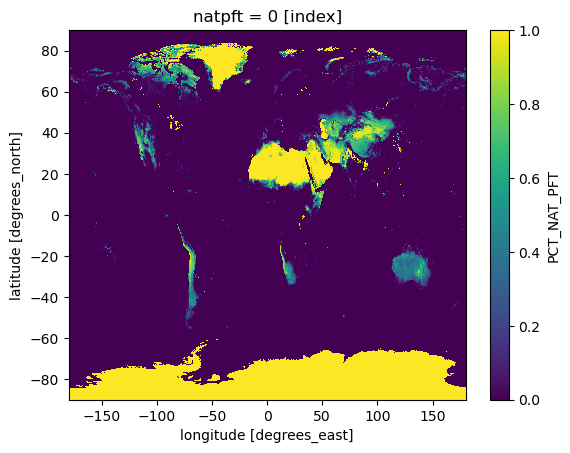

In [56]:
percent[0].plot()

### Renormalized CLM5 data and add to percent list

In [57]:
for data_array in ds_landusepfts:
    percent.append(RenormalizePFTs(data_array))

### Calculate the primary and secondary PFT fractions as the forest

In [58]:
percent[2] = ds_static.fstnf * percent[2] + (1. - ds_static.fstnf) * percent[-1]

### Combine the percetages into a single dataset

In [59]:
ds_var_names = ['frac_brgnd','frac_csurf','frac_primr','frac_pastr','frac_range']

In [60]:
ds_percent = xr.Dataset()
for index,data_array in enumerate(percent):
    ds_percent = ds_percent.merge(data_array.to_dataset(name=ds_var_names[index]))

In [61]:
ds_percent = ds_percent.merge(percent[2].to_dataset(name='frac_secnd'))

### Mask the data

In [62]:
SetMaskLUH2(ds_percent,ds_static);

In [21]:
# Mask the data where the ice/water fraction is unity (i.e. fully ice covered gridcell)
# ds_percent = SetMaskLUH2(ds_percent, ds_static)

In [22]:
# ds_percent["mask"] = xr.where(ds_static.icwtr != 1,1,0)

### Regrid the dataset

In [64]:
dsnew = ds_percent[["natpft","lat","lon","frac_brgnd","frac_primr"]]

In [65]:
regridder = xe.Regridder(dsnew, ds_target, "conservative")
# regridder = xe.Regridder(ds_percent, ds_target, "conservative")
# regridder = xe.Regridder(ds_percent, ds_target, "conservative_normed")
ds_regrid = regridder(dsnew)


/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [20]:
# regrid_land_fraction = regridder(ds_static)

In [21]:
# adjust landuse data by the landuse fraction?
# ds_regrid = ds_regrid / regrid_land_fraction.landfrac

### Review the regridded data

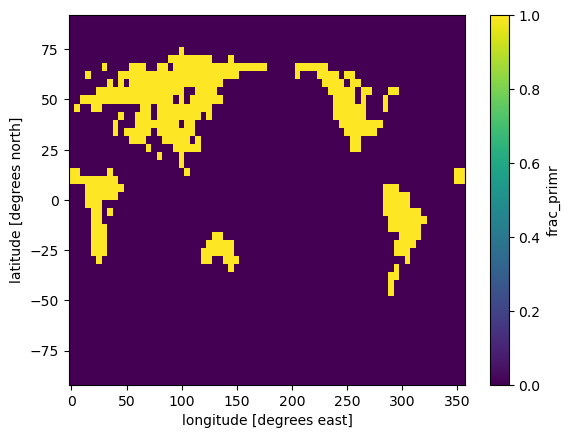

In [68]:
ds_regrid.frac_primr.sum(dim='natpft').plot()

In [54]:
varnames = ['frac_csurf', 'frac_primr', 'frac_pastr', 'frac_range', 'frac_secnd']
dsnew = ds_regrid[varnames].sum(dim='natpft')

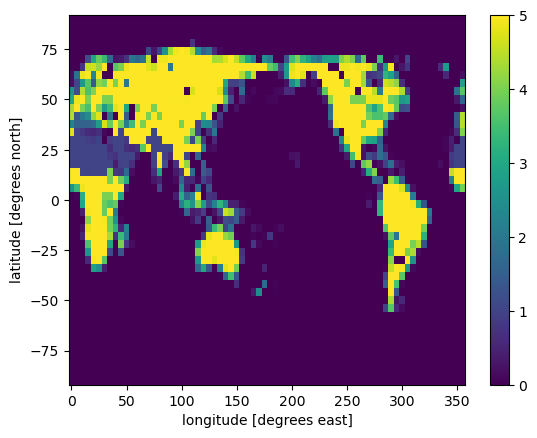

In [59]:
dsnew.to_array().sum(dim='variable').plot()

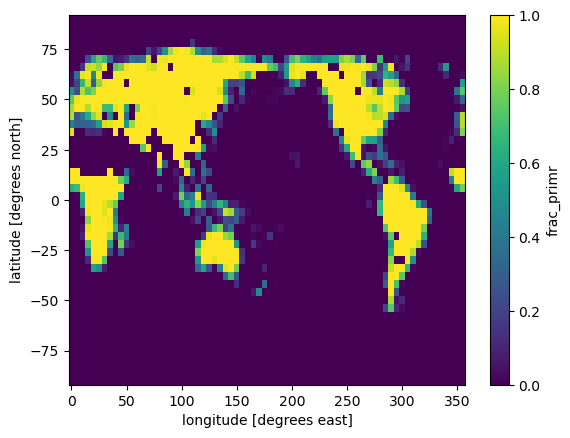

In [60]:
dsnew.frac_primr.plot()

#### Bareground (compare)

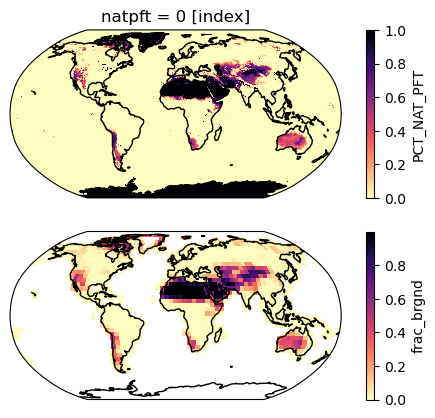

In [19]:
ax1 = plt.subplot(211, projection=ccrs.Robinson())
percent_bareground.plot(cmap='magma_r', transform=ccrs.PlateCarree())
ax1.coastlines()
ax2 = plt.subplot(212,projection=ccrs.Robinson())
ds_regrid.frac_brgnd.plot(cmap='magma_r', transform=ccrs.PlateCarree())
ax2.coastlines()

#### Primary + Secondary (regrid)

/tmp/ipykernel_98690/941046407.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in fg.axes.flat:


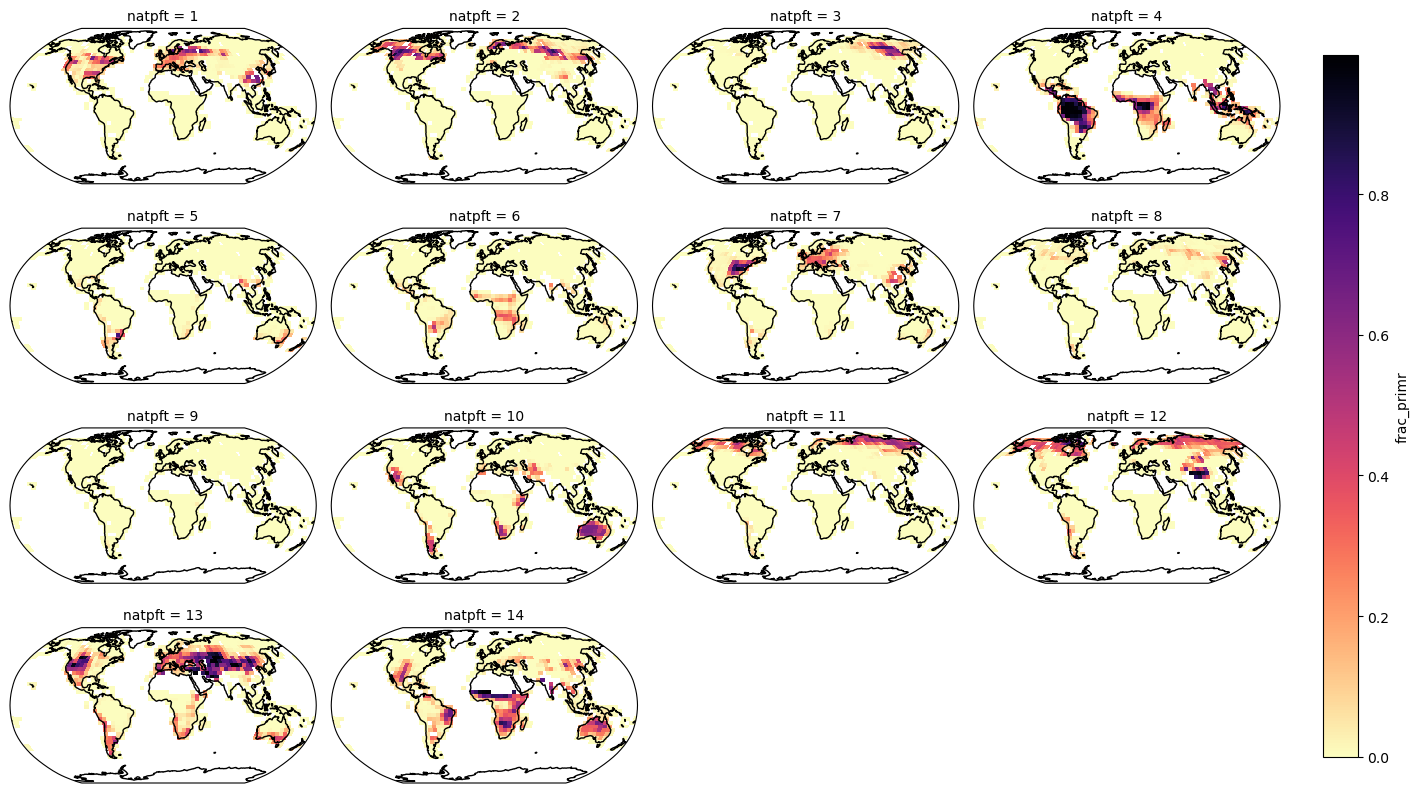

In [20]:
plotnatpft(ds_regrid.frac_primr)

#### Primary + Secondary (compare single natpft)

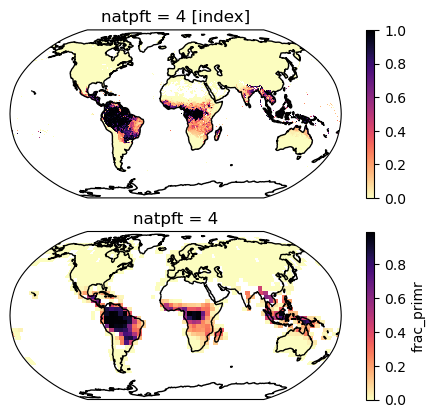

In [24]:
inatpft = 3 
ax1 = plt.subplot(211, projection=ccrs.Robinson())
percent[2].isel(natpft=inatpft).plot(cmap='magma_r', transform=ccrs.PlateCarree())
ax1.coastlines()
ax2 = plt.subplot(212,projection=ccrs.Robinson())
ds_regrid.frac_primr.isel(natpft=inatpft).plot(cmap='magma_r', transform=ccrs.PlateCarree())
ax2.coastlines()

### Export the dataset

In [19]:
# Convert the coordinate names
ds_regrid = ds_regrid.rename_dims(dims_dict={'lat':'lsmlat','lon':'lsmlon'})

In [20]:
ds_regrid.to_netcdf('fates_landuse_pft_map_4x5_no-luh2mask.nc')